In [1]:
!pip install pyspark
!pip install findspark
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=3cb329b71d29dfd7fec02fc45f57db1863376eadf2b82bd76b10e6e848c7cb48
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# Data Exploration and Cleaning

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [30]:
dataset= pd.read_csv("kick_starter.csv")

In [18]:
dataset.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0.0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15.0,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3.0,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1.0,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14.0,US,1283.0,1283.0,19500.00


In [19]:
print(dataset.info())#should drop useless coulmns ex:usd_pledged since we will just use ths usd one 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95504 entries, 0 to 95503
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                95504 non-null  int64  
 1   name              95504 non-null  object 
 2   category          95504 non-null  object 
 3   main_category     95504 non-null  object 
 4   currency          95504 non-null  object 
 5   deadline          95504 non-null  object 
 6   goal              95504 non-null  float64
 7   launched          95503 non-null  object 
 8   pledged           95503 non-null  float64
 9   state             95503 non-null  object 
 10  backers           95503 non-null  float64
 11  country           95503 non-null  object 
 12  usd pledged       94561 non-null  float64
 13  usd_pledged_real  95503 non-null  float64
 14  usd_goal_real     95503 non-null  float64
dtypes: float64(6), int64(1), object(8)
memory usage: 10.9+ MB
None


In [20]:
print(dataset.describe())

                 ID          goal       pledged       backers   usd pledged  \
count  9.550400e+04  9.550400e+04  9.550300e+04   95503.00000  9.456100e+04   
mean   1.129848e+09  4.607352e+04  9.569224e+03     105.09785  6.975495e+03   
std    3.642964e+08  1.131257e+06  8.339510e+04     898.03913  6.606629e+04   
min    1.061440e+05  1.000000e+00  0.000000e+00       0.00000  0.000000e+00   
25%    1.080583e+09  2.000000e+03  3.100000e+01       2.00000  1.857000e+01   
50%    1.216069e+09  5.150000e+03  6.250000e+02      12.00000  4.000000e+02   
75%    1.351120e+09  1.600000e+04  4.100000e+03      56.00000  3.048000e+03   
max    1.485336e+09  1.000000e+08  8.596475e+06  154926.00000  8.596475e+06   

       usd_pledged_real  usd_goal_real  
count      9.550300e+04   9.550300e+04  
mean       8.988647e+03   4.282420e+04  
std        7.959877e+04   1.160958e+06  
min        0.000000e+00   4.900000e-01  
25%        3.100000e+01   2.000000e+03  
50%        6.254400e+02   5.498000e+03  
7

In [21]:
print(dataset.dtypes)

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers             float64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object


In [31]:
null_percentage = (dataset.isnull().sum() / len(dataset)) * 100

print("Null Percentage for each column:")
print(null_percentage)

Null Percentage for each column:
ID                  0.000000
name                0.000000
category            0.000733
main_category       0.000733
currency            0.000733
deadline            0.000733
goal                0.000733
launched            0.000733
pledged             0.000733
state               0.000733
backers             0.000733
country             0.000733
usd pledged         0.989221
usd_pledged_real    0.000733
usd_goal_real       0.000733
dtype: float64


In [32]:
dataset.dropna(inplace=True)

In [33]:
# Unique values in the 'currency' column
unique_currencies = dataset['currency'].unique()
print("Unique currencies:", unique_currencies)

Unique currencies: ['GBP' 'USD' 'CAD' 'AUD' 'NOK' 'EUR' 'MXN' 'SEK' 'NZD' 'CHF' 'DKK' 'HKD'
 'SGD' 'JPY']


In [34]:
# Check for duplicates
duplicates = dataset[dataset.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [ID, name, category, main_category, currency, deadline, goal, launched, pledged, state, backers, country, usd pledged, usd_pledged_real, usd_goal_real]
Index: []


In [35]:
# Check for negative values in numeric columns
numeric_cols = ['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']
negative_values = dataset[dataset[numeric_cols] < 0].dropna()
if not negative_values.empty:
    print("Negative values found in numeric columns:")
    print(negative_values)

In [36]:
# Check for invalid dates
invalid_dates = dataset[~pd.to_datetime(dataset['deadline'], errors='coerce').notna() | ~pd.to_datetime(dataset['launched'], errors='coerce').notna()]
if not invalid_dates.empty:
    print("Invalid dates found:")
    print(invalid_dates)

In [37]:
# Unique values in the 'country' column
unique_countries = dataset['country'].unique()
print("Unique countries:", unique_countries)

# Unique values in the 'state' column
unique_states = dataset['state'].unique()
print("Unique states:", unique_states)

Unique countries: ['GB' 'US' 'CA' 'AU' 'NO' 'IT' 'DE' 'IE' 'MX' 'ES' 'SE' 'FR' 'NL' 'NZ'
 'CH' 'AT' 'DK' 'BE' 'HK' 'LU' 'SG' 'JP']
Unique states: ['failed' 'canceled' 'successful' 'live' 'suspended']


In [38]:
# Unique values in the 'currency' column
unique_currencies = dataset['currency'].unique()
print("Unique currencies:", unique_currencies)

Unique currencies: ['GBP' 'USD' 'CAD' 'AUD' 'NOK' 'EUR' 'MXN' 'SEK' 'NZD' 'CHF' 'DKK' 'HKD'
 'SGD' 'JPY']


In [39]:
from scipy import stats

# Define the numerical columns to check for outliers
numerical_columns = ['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']

# Calculate Z-scores for each numerical column
z_scores = stats.zscore(dataset[numerical_columns])

# Calculate absolute Z-scores and create a mask for outliers
z_score_abs = np.abs(z_scores)
outlier_mask = (z_score_abs < 3).all(axis=1)  # Adjust the threshold as needed

# Calculate the number of outliers removed
outliers_removed = len(dataset) - np.sum(outlier_mask)

# Remove outliers from the original DataFrame
dataset = dataset[outlier_mask]

# Display information about removed outliers
print("Number of outliers removed:", outliers_removed)

Number of outliers removed: 1231


In [40]:
# Filter rows where 'name' contains 'null (Canceled)'
dataset = dataset[~dataset['name'].str.lower().str.contains("null \(canceled\)")]

In [41]:
# Select numeric columns
numeric_columns = dataset.select_dtypes(include=['int', 'float']).columns

# Check for NULL values in numeric columns
nulls_in_numeric_columns = dataset[numeric_columns].isnull().sum()

# Print the NULL counts for numeric columns
print("NULL counts in numeric columns:")
print(nulls_in_numeric_columns)

NULL counts in numeric columns:
ID                  0
goal                0
pledged             0
backers             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64


# Queries

In [42]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("KickstarterAnalysis") \
    .getOrCreate()

# Load the dataset
df = spark.createDataFrame(dataset)
# Register DataFrame as a SQL temporary view
df.createOrReplaceTempView("kick")

In [ ]:

# Success rate by country
query1 = spark.sql("""
    SELECT country,
           SUM(CASE WHEN state = 'successful' THEN 1 ELSE 0 END) / COUNT(*) *100 AS success_rate
    FROM kick
    GROUP BY country
    ORDER BY success_rate DESC
""")
query1.show()

+-------+------------------+
|country|      success_rate|
+-------+------------------+
|     US|37.446633318923816|
|     GB| 35.81052181351583|
|     HK|35.521235521235525|
|     SG|32.758620689655174|
|     DK|32.723358449946176|
|     FR|31.186302486750918|
|     NZ| 30.76271186440678|
|     LU|              30.0|
|     SE| 28.30832196452933|
|     CA|27.705944539318534|
|     IE|26.362297496318117|
|     AU|25.797012166949024|
|     CH|25.581395348837212|
|     BE| 24.85549132947977|
|     MX|22.465753424657535|
|     DE|22.420749279538903|
|     NO| 22.22222222222222|
|     ES|21.730067743616466|
|     NL|21.576939381093684|
|     AT|17.928286852589643|
+-------+------------------+
only showing top 20 rows



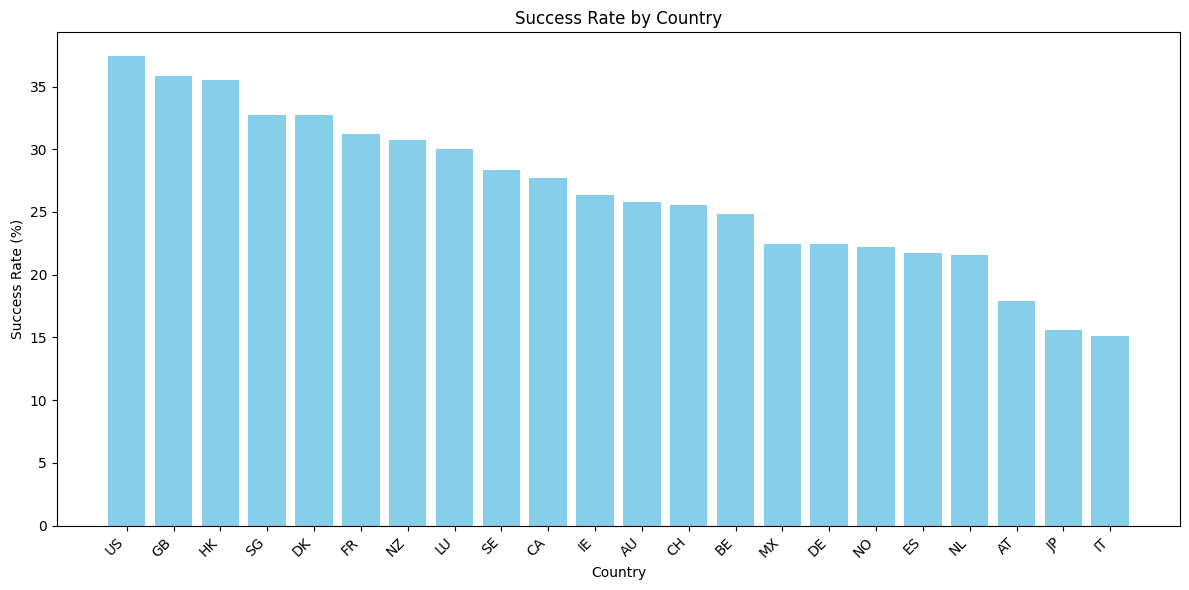

In [ ]:
import matplotlib.pyplot as plt

# Convert query result to Pandas DataFrame
query1_df = query1.toPandas()

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(query1_df['country'], query1_df['success_rate'], color='skyblue')
plt.title('Success Rate by Country')
plt.xlabel('Country')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [45]:
#Query : Find the top 10 projects with the highest pledged amounts
query2 =spark.sql( """
SELECT name, main_category, pledged
FROM kick
ORDER BY pledged DESC
LIMIT 10
""")

query2.show()

+--------------------+-------------+---------+
|                name|main_category|  pledged|
+--------------------+-------------+---------+
|The Ultimate Tita...|       Design| 240077.0|
|The Beast - A Lar...|   Technology| 237572.0|
|Herman Hedning 19...|       Comics| 237024.0|
|AMK Morgon- Ditt ...|   Journalism| 236300.5|
|iMusicThings - Th...|   Technology| 233235.0|
|Ruta Origen: Trav...|         Food|233017.79|
|The Palette: 3D P...|   Technology|231803.55|
|NOLO: Affordable ...|   Technology| 231491.0|
|ARMBOT: Affordabl...|   Technology| 231036.0|
|Enchant your phot...|  Photography|230135.34|
+--------------------+-------------+---------+



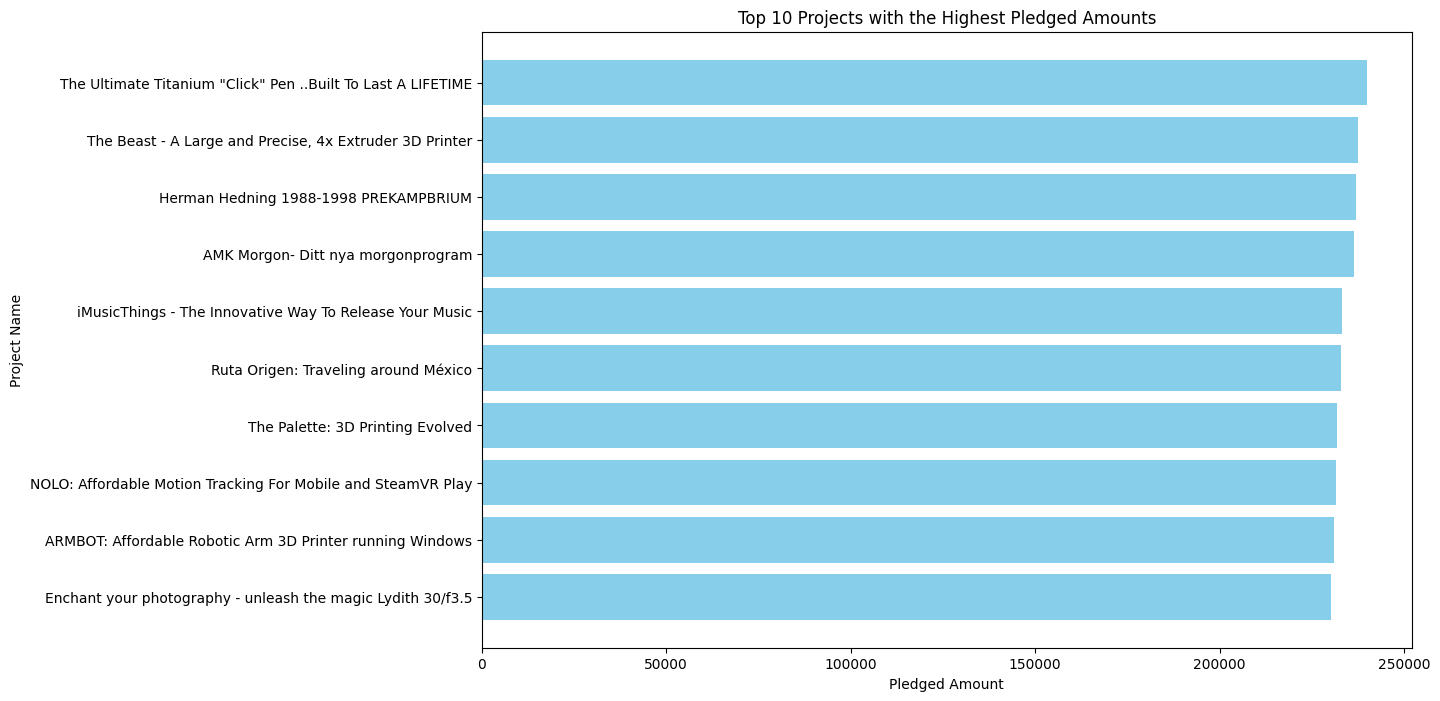

In [49]:
# Collect the results to a Pandas DataFrame for visualization
top_pledged_projects = query2.toPandas()

# Set up the figure and axis
plt.figure(figsize=(12, 8))

# Plot the data
plt.barh(top_pledged_projects['name'], top_pledged_projects['pledged'], color='skyblue')

# Invert the y-axis to show the project with the highest pledge on top
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Pledged Amount')
plt.ylabel('Project Name')
plt.title('Top 10 Projects with the Highest Pledged Amounts')

# Show the plot
plt.show()

In [46]:
# Query: Projects where pledged amount exceeds the goal
query3 = spark.sql("""
    SELECT
        name,
        main_category,
        (usd_pledged_real - usd_goal_real) AS amount_exceeded
    FROM
        kick
    WHERE
        usd_pledged_real > usd_goal_real
    ORDER BY
        amount_exceeded DESC
""")


query3.show()

+--------------------+-------------+------------------+
|                name|main_category|   amount_exceeded|
+--------------------+-------------+------------------+
|RE-LOAD by Archon...|        Games|          218660.0|
|Platypod Ultra (+...|  Photography|          206337.0|
|Nagasaki Knife Co...|       Design|         205816.03|
|XPUMP | TURN ANY ...|   Technology|          202673.0|
|Dreamcade Replay ...|        Games|         198854.01|
|DRAGONLOCK 3: Dan...|        Games|          191238.0|
|Bit Bar : The Poc...|       Design|          190611.0|
|Titanium - Placin...|       Design|         190343.59|
|Dice Hospital - a...|        Games|         190001.24|
|Luxury Watches Ma...|      Fashion|         189202.25|
|The Yellow King R...|        Games|189014.59999999998|
|Mutant Crawl Clas...|        Games|         186806.86|
|Bold Dress Shoes ...|      Fashion|          186133.0|
|Straton Speciale ...|       Design|185744.13999999998|
|       Age of Towers|        Games|         184

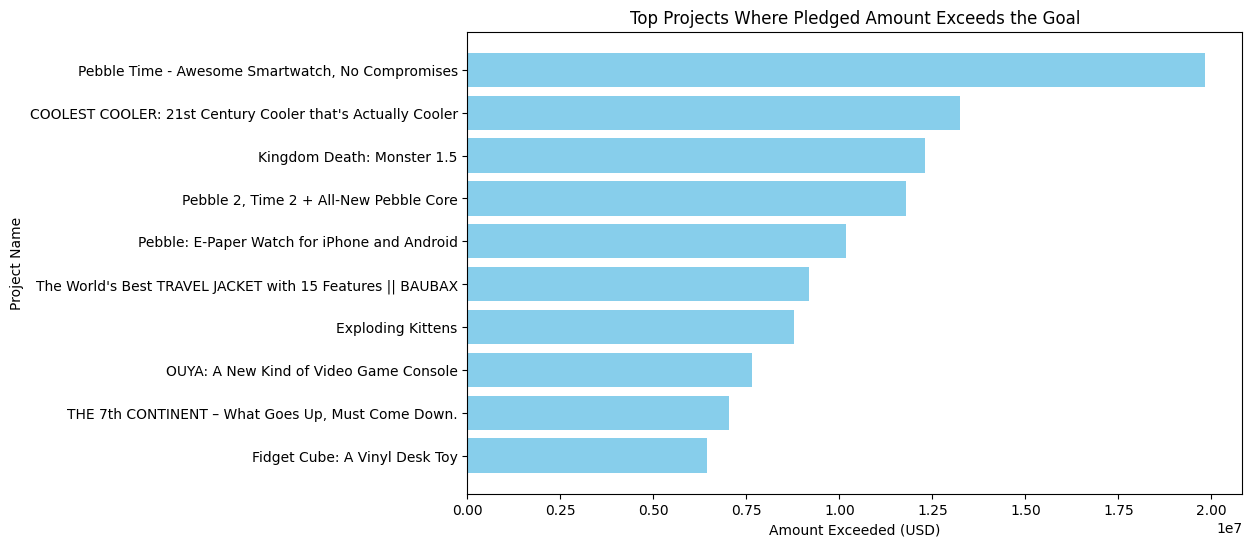

In [ ]:
# Convert query result to Pandas DataFrame
query3_df = query3.toPandas()

# Take the top 10 projects with the highest amounts exceeded
top_projects = query3_df.head(10)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_projects['name'], top_projects['amount_exceeded'], color='skyblue')
plt.xlabel('Amount Exceeded (USD)')
plt.ylabel('Project Name')
plt.title('Top Projects Where Pledged Amount Exceeds the Goal')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest amount exceeded at the top
plt.show()


In [48]:
#extra query :)
query4 = spark.sql("""
SELECT state, COUNT(*) AS project_count
FROM kick
GROUP BY state
ORDER BY project_count DESC
""")

query4.show()


+----------+-------------+
|     state|project_count|
+----------+-------------+
|    failed|        70723|
|successful|        47584|
|  canceled|        13933|
|      live|         1006|
| suspended|          642|
+----------+-------------+



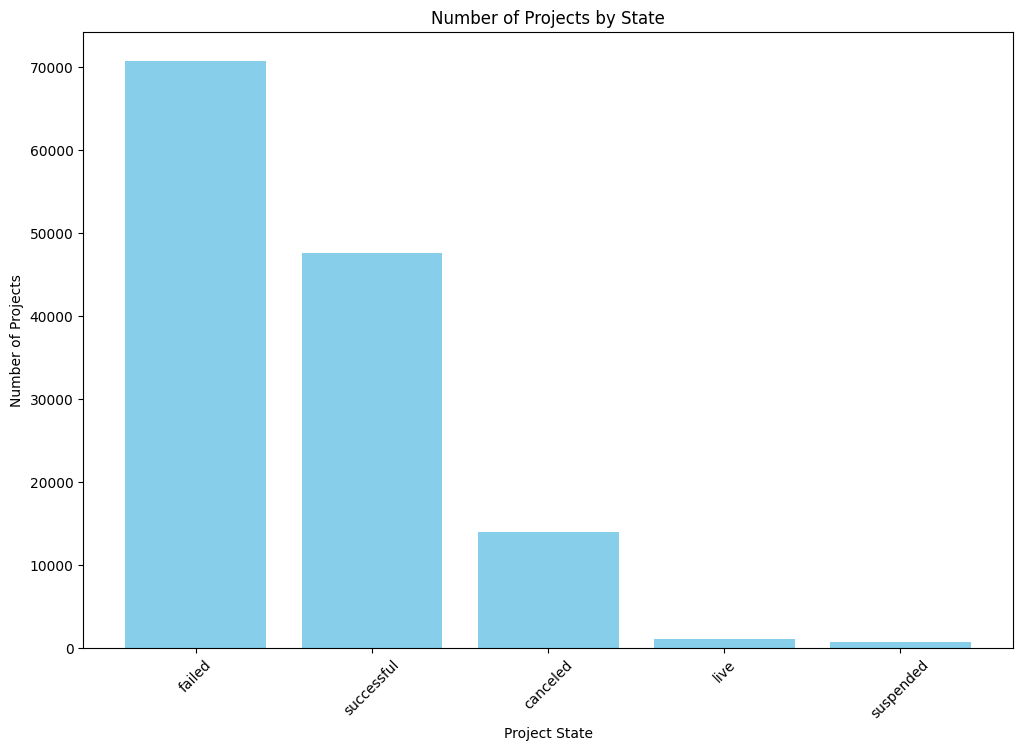

In [50]:
# Collect the results to a Pandas DataFrame for visualization
projects_by_state = query4.toPandas()
# Set up the figure and axis
plt.figure(figsize=(12, 8))

# Plot the data
plt.bar(projects_by_state['state'], projects_by_state['project_count'], color='skyblue')

# Add labels and title
plt.xlabel('Project State')
plt.ylabel('Number of Projects')
plt.title('Number of Projects by State')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Prepare target column
df = df.filter(df['state'] != 'live')  # Drop projects that are "live"
df = df.withColumn('outcome', (df['state'] == 'successful').cast('int'))  # Convert "successful" to 1, others to 0

# Define categorical columns
categorical_cols = ['category', 'main_category', 'currency', 'country']

# Convert categorical columns to numerical representations
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vec") for col in categorical_cols]

# Combine feature columns into a single vector column
feature_cols = [col + "_vec" for col in categorical_cols] + ['goal', 'backers']##goal should have been usd
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Define models
lr = LogisticRegression(labelCol='outcome', featuresCol='features')
rf = RandomForestClassifier(labelCol='outcome', featuresCol='features')
gbt = GBTClassifier(labelCol='outcome', featuresCol='features')

# Define pipeline
pipeline_lr = Pipeline(stages=indexers + encoders + [vector_assembler, lr])
pipeline_rf = Pipeline(stages=indexers + encoders + [vector_assembler, rf])
pipeline_gbt = Pipeline(stages=indexers + encoders + [vector_assembler, gbt])

# Split data into train and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Train models
model_lr = pipeline_lr.fit(train_data)
model_rf = pipeline_rf.fit(train_data)
model_gbt = pipeline_gbt.fit(train_data)

# Evaluate models
evaluator = BinaryClassificationEvaluator(labelCol='outcome', rawPredictionCol='prediction', metricName='areaUnderROC')
lr_auc = evaluator.evaluate(model_lr.transform(test_data))
rf_auc = evaluator.evaluate(model_rf.transform(test_data))
gbt_auc = evaluator.evaluate(model_gbt.transform(test_data))

print("Logistic Regression AUC:", lr_auc)
print("Random Forest AUC:", rf_auc)
print("GBT AUC:", gbt_auc)

Logistic Regression AUC: 0.8549880229118493
Random Forest AUC: 0.7827077311116096
GBT AUC: 0.9254532316762004


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='outcome', predictionCol='prediction', metricName='accuracy')

# Evaluate models
lr_accuracy = evaluator.evaluate(model_lr.transform(test_data))
rf_accuracy = evaluator.evaluate(model_rf.transform(test_data))
gbt_accuracy = evaluator.evaluate(model_gbt.transform(test_data))

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("GBT Accuracy:", gbt_accuracy)

Logistic Regression Accuracy: 0.8836483580448526
Random Forest Accuracy: 0.8258120846605332
GBT Accuracy: 0.9263990169288728
